# Dataset

In [77]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/eduardofc/data/main/amazon_sports.csv")
df['review_body'] = df['review_body'].str.replace("[^a-zA-ZñÑáéíóú .,]", "", regex=True)
df['review_body'] = df['review_body'].str.lower()
df.head()

,stars,review_body,review_title,product_category
0,1,nunca llego el pedido y el vendedor pasa de to...,No llego nunca,sports
1,1,"no sé como es, porque debería haber llegado ay...",Todavía no ha llegado,sports
2,1,"guantes cómodos, no lo niego, pero de mala cal...",Guantes de baja calidad,sports
3,1,hasta hoy no he visto el producto. el pedido h...,Muy Mala experiencia,sports
4,1,"no puedo valorarla porque, después de casi una...",Paquete perdido?,sports


In [78]:
df.groupby("stars").size()

stars
1    2438
2    2551
3    2828
4    2860
5    2512
dtype: int64

In [79]:
df = df[df.stars!=3]

df['good_product'] = (df.stars > 3).astype(int)
df.head()

,stars,review_body,review_title,product_category,good_product
0,1,nunca llego el pedido y el vendedor pasa de to...,No llego nunca,sports,0
1,1,"no sé como es, porque debería haber llegado ay...",Todavía no ha llegado,sports,0
2,1,"guantes cómodos, no lo niego, pero de mala cal...",Guantes de baja calidad,sports,0
3,1,hasta hoy no he visto el producto. el pedido h...,Muy Mala experiencia,sports,0
4,1,"no puedo valorarla porque, después de casi una...",Paquete perdido?,sports,0


In [80]:
df.groupby("good_product").size()

good_product
0    4989
1    5372
dtype: int64

# Modeling classification

In [81]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [82]:
X = df.review_body.values
y = df.good_product.values

In [83]:
vocab_size = 10000

tokenizer = Tokenizer(
    num_words=vocab_size,
    oov_token='<OOV>'
)
tokenizer.fit_on_texts(X)
# tokenizer.index_word

tokenized_X = tokenizer.texts_to_sequences(X)

In [84]:
padded_X = pad_sequences(
    tokenized_X,
    maxlen=50,
    truncating='post'
)
# padded_X

## Modelo de keras

In [85]:
import tensorflow.keras as keras
from keras import Sequential
from keras.layers import Embedding, Flatten, Dense

keras.utils.set_random_seed(812)

In [86]:
embd_dim = 2

model = Sequential()
model.add(
    Embedding(
        input_dim=vocab_size,
        output_dim=embd_dim,
        input_length=50
    )
)
model.add(Flatten())
model.add(Dense(units=6, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [87]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 2)             20000     
                                                                 
 flatten_1 (Flatten)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 6)                 606       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 20613 (80.52 KB)
Trainable params: 20613 (80.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [88]:
model.fit(padded_X, y, epochs=20)

Epoch 1/20
324/324 [==============================] - 1s 2ms/step - loss: 0.6688 - accuracy: 0.5648
Epoch 2/20
324/324 [==============================] - 1s 2ms/step - loss: 0.4962 - accuracy: 0.8134
Epoch 3/20
324/324 [==============================] - 1s 2ms/step - loss: 0.3842 - accuracy: 0.8844
Epoch 4/20
324/324 [==============================] - 1s 2ms/step - loss: 0.3139 - accuracy: 0.9167
Epoch 5/20
324/324 [==============================] - 1s 2ms/step - loss: 0.2603 - accuracy: 0.9340
Epoch 6/20
324/324 [==============================] - 1s 2ms/step - loss: 0.2180 - accuracy: 0.9497
Epoch 7/20
324/324 [==============================] - 1s 2ms/step - loss: 0.1850 - accuracy: 0.9600
Epoch 8/20
324/324 [==============================] - 1s 2ms/step - loss: 0.1594 - accuracy: 0.9656
Epoch 9/20
324/324 [==============================] - 1s 2ms/step - loss: 0.1384 - accuracy: 0.9705
Epoch 10/20
324/324 [==============================] - 1s 2ms/step - loss: 0.1216 - accuracy: 0.9745

# Embeddings layer

In [89]:
embd_layer = model.layers[0]
embd_weights = embd_layer.get_weights()[0]
embd_weights.shape

(10000, 2)

In [90]:
palabras = ['bueno', 'malo', 'horrible']
for k in palabras:
    v = tokenizer.word_index[k]
    print(f"{k} - {v} - {embd_weights[v]}")    

bueno - 92 - [-0.15931392 -0.2208697 ]
malo - 215 - [-0.01917276  0.14353102]
horrible - 1265 - [0.27545732 0.28818738]


In [91]:
words = []
x_axis = []
y_axis = []

for k, v in tokenizer.index_word.items():
    x, y = embd_weights[k]
    words.append(v)
    x_axis.append(x)
    y_axis.append(y)
    if k==1500:
        break

In [92]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource

output_notebook()

source = ColumnDataSource(data=dict(x=x_axis, y=y_axis, words=words))
p = figure(tools="", title="2-dim embeddings space")
p.circle('x', 'y', size=2, source=source)
hover = HoverTool()
hover.tooltips = [("Palabra", "@words"), ("(x,y)", "($x, $y)")]
p.add_tools(hover)

Loading BokehJS ...

In [93]:
show(p)

# Similitud del coseno

In [94]:
import numpy as np

In [95]:
# (comedia, intriga, terror, thriller, aventuras , sci-fi) n=6 dimensiones

v_toy_story = np.array([3, 1, 0, 1, 5, 4])
v_mission_imp = np.array([2, 5, 0, 5, 4, 2])
v_jurassic_park = np.array([1, 2, 1, 3, 5, 3])
v_exorcista = np.array([0, 4, 5, 3, 1, 2])

In [96]:
np.dot(v_toy_story, v_mission_imp)
np.dot(v_toy_story, v_jurassic_park)
np.dot(v_toy_story, v_exorcista)

20

In [97]:
np.dot(v_toy_story / np.linalg.norm(v_toy_story), v_exorcista /  np.linalg.norm(v_exorcista))

0.3739787960033829

In [98]:
np.dot(v_toy_story / np.linalg.norm(v_toy_story), v_jurassic_park /  np.linalg.norm(v_jurassic_park))

0.8914824582191183

In [99]:
def sim_cosine(v1, v2):
    return np.dot(v1 / np.linalg.norm(v1), v2 /  np.linalg.norm(v2))

In [100]:
palabras = ['bueno', 'malo', 'horrible']
for k in palabras:
    v = tokenizer.word_index[k]
    print(f"{k} - {v} - {embd_weights[v]}") 

bueno - 92 - [-0.15931392 -0.2208697 ]
malo - 215 - [-0.01917276  0.14353102]
horrible - 1265 - [0.27545732 0.28818738]


In [101]:
v_bueno = embd_weights[92]
v_malo = embd_weights[215]
v_horrible = embd_weights[1265]

In [102]:
sim_cosine(v_bueno, v_malo)

-0.72643673

In [103]:
sim_cosine(v_malo, v_horrible)

0.62504286

In [104]:
sim_cosine(v_bueno, v_horrible)

-0.9905019

# Word2Vec

In [105]:
reviews = list(df.review_body.values)

In [106]:
sentences = []
for rr in reviews:
    ss = rr.split('.')
    for s in ss:
        s = s.strip()
        if len(s)>1:
            s = s.lower()
            s = s.replace("  ", " ")
            sentences.append(s)

In [107]:
sentences[:10]

['nunca llego el pedido y el vendedor pasa de todo no contestan',
 'no sé como es, porque debería haber llegado ayer día de marzo, y hoy por la noche sigo esperando que llegue el frontal',
 'y me habéis mandado el formulario de opinión',
 'pues de momento mala no ha cumplido con la fecha de entrega',
 'guantes cómodos, no lo niego, pero de mala calidad',
 'yo creo que en caso de caída no valdrian para mucho, dos meses de uso y se están rajando',
 'hasta hoy no he visto el producto',
 'el pedido hace ya casi mes',
 'y notifico que he usado prime para está compra',
 'no puedo valorarla porque, después de casi una semana, aún no he recibido mi pedido']

In [108]:
# !pip install gensim

In [109]:
# !pip install scipy==1.10.1 --force-reinstall

In [110]:
word_sentences = [ss.split() for ss in sentences]

In [111]:
from gensim.models import Word2Vec

model = Word2Vec(
    sentences=word_sentences,
    vector_size=20,    # embeddings
    window=3
)

In [112]:
model.wv['bueno']

array([ 0.29792476, -0.6408479 ,  1.6257905 ,  1.1235002 ,  0.49831492,
        0.38307765,  0.4551121 ,  1.1662357 , -0.5827062 ,  1.2320598 ,
        0.17567821, -0.3445687 ,  0.26817128,  0.16833322,  1.4339726 ,
        0.5646489 ,  1.0710397 ,  0.5944217 , -0.89589614, -0.9906861 ],
      dtype=float32)

In [113]:
model.wv['malo']

array([-0.27345034, -0.18590648,  1.0508721 ,  0.2332425 ,  0.48290405,
        0.1514859 ,  0.649822  ,  1.022653  , -0.6131948 ,  0.49716738,
        0.6488988 , -0.63275415, -0.03317874, -0.15788892,  1.0363977 ,
        0.3770649 ,  0.8731106 ,  0.62523663, -0.75656366, -0.556728  ],
      dtype=float32)

In [114]:
model.wv.most_similar(positive=['ok'])

[('correcto,', 0.9864449501037598),
 ('perfecto,', 0.9763268232345581),
 ('metálica', 0.9735439419746399),
 ('preciso', 0.9696202874183655),
 ('protegido', 0.9692942500114441),
 ('ojo', 0.9683215022087097),
 ('rápida', 0.966799259185791),
 ('rapido', 0.9665030241012573),
 ('perfectas,', 0.9664310812950134),
 ('perfectos,', 0.9664070010185242)]

In [115]:
model.wv.similarity("bueno", "cómodo")

0.95211506

## Plotear

In [116]:
words1 = [w for w, _ in model.wv.most_similar(positive=['bueno'])]
words2 = [w for w, _ in model.wv.most_similar(positive=['malos'])]

In [117]:
words = words1 + words2

In [118]:
from sklearn.decomposition import PCA

X = model.wv[words]
pca = PCA(n_components=2)
results = pca.fit_transform(X)

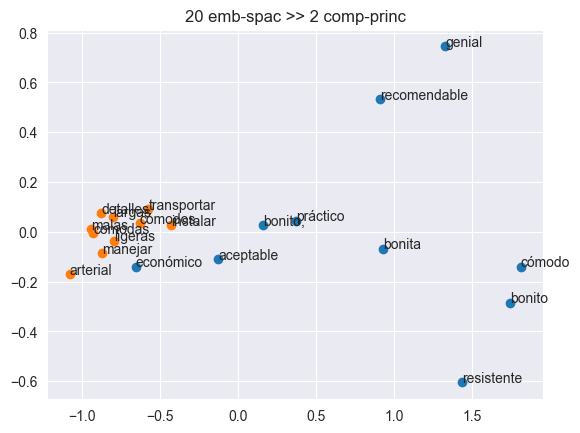

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')


plt.scatter(results[:len(words1), 0], results[:len(words1), 1])
plt.scatter(results[len(words1):, 0], results[len(words1):, 1])
for i, w in enumerate(words):
    plt.annotate(w, xy=(results[i, 0], results[i,1]))
plt.title("20 emb-spac >> 2 comp-princ")
plt.show()

# Sentence Transformer

In [120]:
df_st = df.sample(2000, replace=False, random_state=99)

reviews = list(df_st['review_body'].values)
print(len(reviews))
reviews[:2]

2000


['lo quería porque trabajo en un club de fútbol y parece una buena herramienta. el problema está que no llegó nunca, y amazon me reembolsó lo pagado.',
 'por el precio está bien, aunque la calidad es media. tampoco lo veo tan sólido como para poner mucho peso.']

In [121]:
df_st.groupby('good_product').size()

good_product
0     977
1    1023
dtype: int64

## Model de ST

In [122]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")

In [123]:
embeddings = model.encode(reviews, show_progress_bar=True)

Batches: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [02:13<00:00,  2.11s/it]


In [126]:
embeddings[0].shape

(768,)

## Visualization

In [128]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    n_iter=500
)

tsne_data = tsne.fit_transform(embeddings)

In [129]:
tsne_data[0]

array([-24.678457  ,   0.05576559], dtype=float32)

In [130]:
df_st[['x', 'y']] = tsne_data
df_st.head()

,stars,review_body,review_title,product_category,good_product,x,y
1187,1,lo quería porque trabajo en un club de fútbol ...,Que llegue el producto,sports,0,-24.678457,0.055766
8602,4,"por el precio está bien, aunque la calidad es ...",Calidad media,sports,1,-8.078467,-7.800977
10734,5,"la correa encaja perfectamente, viene con todo...",Correa de sustitución,sports,1,10.702372,-9.393636
10822,5,"ha sido una buena compra, después de dos seman...",Excelente producto,sports,1,7.774596,-7.845394
8985,4,"dan el pego vaya que si, tengo la misma en dos...",Buena compra,sports,1,-4.312432,-10.103324


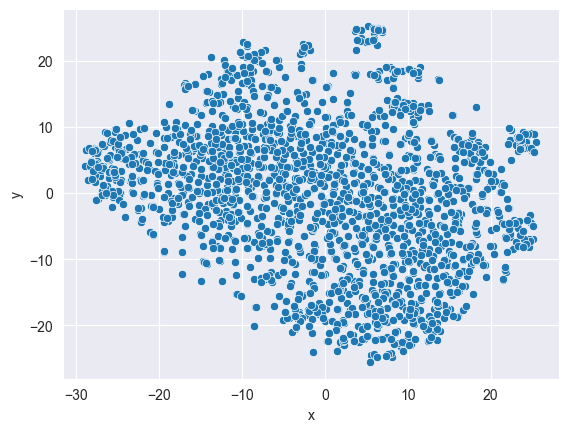

In [131]:
sns.scatterplot(data=df_st, x='x', y='y')
plt.show()

In [132]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.palettes import Viridis256
from bokeh.transform import linear_cmap

source = ColumnDataSource(data={
    "x": df_st['x'],
    "y": df_st['y'],
    "code": df_st['good_product'],
    "post":df_st['review_body']
})

mapper = linear_cmap(
    field_name='code', 
    palette=Viridis256, 
    low=0, high=2
)

p = figure(width=800, height=700, tools="pan,wheel_zoom,box_zoom,reset,hover,save")
p.circle('x', 'y', size=4, source=source, color=mapper, legend_group='code')

hover = p.select_one(HoverTool)
hover.tooltips = [
    ("Post", "@post"),
]

In [133]:
show(p)